In [ ]:
!pip install git+https://github.com/mvaldenegro/keras-uncertainty
# !git clone https://github.com/mvaldenegro/UncertaintyML-course-ESSAI-labs

  Cloning https://github.com/mvaldenegro/keras-uncertainty to /tmp/pip-req-build-5y2abmcd
  Running command git clone --filter=blob:none --quiet https://github.com/mvaldenegro/keras-uncertainty /tmp/pip-req-build-5y2abmcd
  Resolved https://github.com/mvaldenegro/keras-uncertainty to commit 42f50a36c70003b16b7f343002766708ad2a289a
  Preparing metadata (setup.py) ... done
  Created wheel for Keras-Uncertainty: filename=Keras_Uncertainty-0.0.1-py3-none-any.whl size=37767 sha256=7662b09efcd003a2b07d85edeebc01ab01ea1c2ba60925b3e2a38b2386ef463b
  Stored in directory: /tmp/pip-ephem-wheel-cache-t5kfw7ut/wheels/0f/e9/fe/f6021c41f51978e09980019aa4b827d65ad4d3eca0c85be79a
Successfully built Keras-Uncertainty


In [ ]:
import keras
from keras import backend as K
import tensorflow as tf
import tensorflow_datasets as tfds
import math

from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics as M
import pandas as pd
# from google.colab import files

import keras_uncertainty as ku
import requests



## Out-of-Distribution (OOD) Detection

ML models are trained on finite datasets which can encompass a finite variability of data.
Many of these models (especially NNs) are generally trained to produce highly-confident predictions even when presented with data which lies outside of the training distribution.

When referencing to NNs for image classification (e.g., cats vs dogs) we might have several situations when a well-trained model might fail:
* a model is presented with an image of a cat which is very different From the other cat images in the dataset (**unknown knowns**---the image comes from a known class, but the training dataset is not comprehensive enough to encompass for the sufficient variability of the data within this class).
* a model is presented with an image of a bird (**unkwnown unknows**---the image comes from a category which is **external** to the ones it was trained to recognize, but the model is not aware of the existence of other categories besides cat and dog).

OOD detection refers to the task of identifying whether some data do not overlap with the training distribution.
By adding some formalization, we call $\mathcal{X}$ the training distribution.
Let us call $\mathcal{U}$ the _universe_ distribution of the data type of the input of our model.
If our NN takes in images of size $h\times w$, we might think $\mathcal{U}$ as encompassing all possible images, i.e., all combinations of pixels in the range $[0-255]$.
The idea of OOD is to identify whether a test sample $x^\star$ comes from ${\mathcal{X}}$ or $\mathcal{U}\setminus{\mathcal{X}}$.


### A practical example of OOD failure with NNs

In the next code cells, we will be training a (frequentist) NN on MNIST and showcase a range of failures on some unknown unknowns and known unknowns.

In [ ]:
model_mnist = keras.Sequential([
    keras.layers.Input((28, 28, 1)), # data as image: heigth x width x channels. MNIST is grayscale » 1 channel
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(10),
    keras.layers.Activation("softmax")
])

model_mnist.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_mnist.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 16)                12560     
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 10)                170       
                                                                 
 activation_5 (Activation)   (None, 10)                0         
                                                                 
Total params: 13002 (50.79 KB)
Trainable params: 13002 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def preprocess_data(data):
  '''
  Changes data type to float32, normalizes in [0,1] range, and add a channel singleton dimension
  '''
  return np.expand_dims(data.astype("float32"), -1) / 255

x = preprocess_data(x)
x_test = preprocess_data(x_test)

y = keras.utils.to_categorical(y, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
def download_weights(url, destination_filename):
  request = requests.get(url)
  with open(destination_filename, 'wb') as outfile:
      outfile.write(request.content)

download_weights("https://www.zullich.it/misc/nn_mnist_weights.keras", "nn_mnist_weights.keras")
model_mnist.load_weights("nn_mnist_weights.keras")

In [ ]:
# Uncomment if you wish to train
# model_mnist.fit(x, y, batch_size=128, epochs=15)

Epoch 1/15
469/469 [==============================] - 3s 3ms/step - loss: 0.5954 - accuracy: 0.8341
Epoch 2/15
469/469 [==============================] - 2s 5ms/step - loss: 0.2781 - accuracy: 0.9198
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.2414 - accuracy: 0.9295
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.2183 - accuracy: 0.9370
Epoch 5/15
469/469 [==============================] - 2s 3ms/step - loss: 0.2031 - accuracy: 0.9413
Epoch 6/15
469/469 [==============================] - 3s 6ms/step - loss: 0.1911 - accuracy: 0.9441
Epoch 7/15
469/469 [==============================] - 4s 9ms/step - loss: 0.1817 - accuracy: 0.9466
Epoch 8/15
469/469 [==============================] - 5s 10ms/step - loss: 0.1733 - accuracy: 0.9485
Epoch 9/15
469/469 [==============================] - 3s 7ms/step - loss: 0.1661 - accuracy: 0.9516
Epoch 10/15
469/469 [==============================] - 3s 7ms/step - loss: 0.1587 - accuracy: 0.952

In [ ]:
# uncomment to save weights
# from google.colab import files
# model_mnist.save_weights("nn_mnist_weights.keras")
# files.download("nn_mnist_weights.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Get the predictions...

In [ ]:
mnist_test_predictions = model_mnist.predict(x_test)
mnist_test_correct_predictions = (mnist_test_predictions.argmax(axis=1) == y_test.argmax(axis=1))
mnist_test_accuracy = mnist_test_correct_predictions.mean()
mnist_test_accuracy

313/313 [==============================] - 0s 1ms/step


0.9491

Let's now evaluate our model with a randomly generated image within the $[0-1]$ range

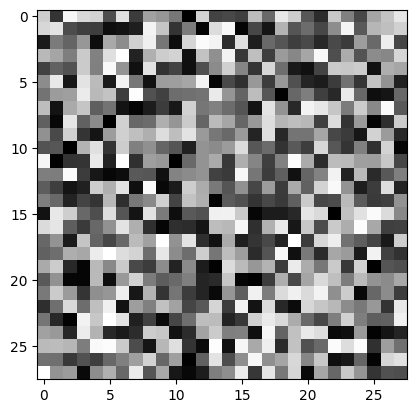

In [ ]:
random_image = np.random.rand(28,28)
plt.imshow(random_image, cmap="gray")

In [ ]:
def predict_and_plot(image, model, normalize=False):
  if normalize:
    image = image / 255
  model_output = model.predict(image)
  _=plt.bar(x=np.arange(0,10), height=model_output.squeeze())
  _=plt.xticks(np.arange(0,10))

1/1 [==============================] - 0s 25ms/step


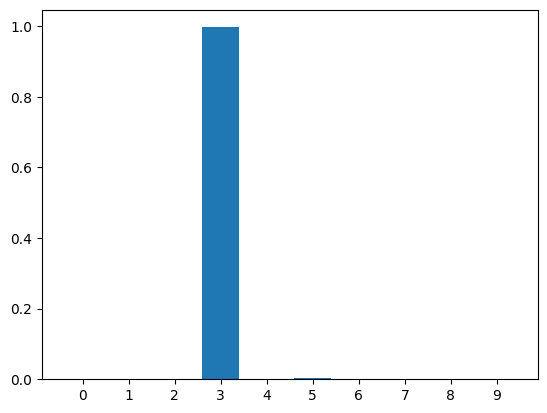

In [ ]:
predict_and_plot(np.expand_dims(random_image, (0, -1)), model_mnist)

**Q: _The above image is an example of..._**
1. **_known known_**
2. **_unknown known_**
3. **_known unknown_**
4. **_unknown unknown_**

Answer: the data is an unknown unknown: the image does not come from any of the classes within the training set, and the model does not know of the existence of these additional images.

**Q: _What can you say on the behavior of the model in this case?_**

The model is extremely confident that the image is a 5, which points at possible miscalibration (overconfidence), although calibration **needs to be evaluated on an aggregate basis---it cannot be evaluated on a single data point**.

Let's try with another example...

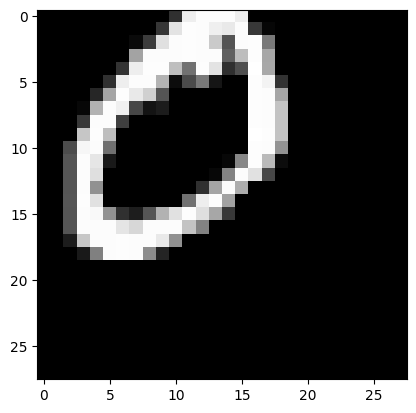

In [ ]:
shifted_img = np.zeros((28,28,1))
shifted_img[:20,:21] = x[1,5:25,4:25] / 255
plt.imshow(shifted_img, cmap="gray")

1/1 [==============================] - 0s 26ms/step


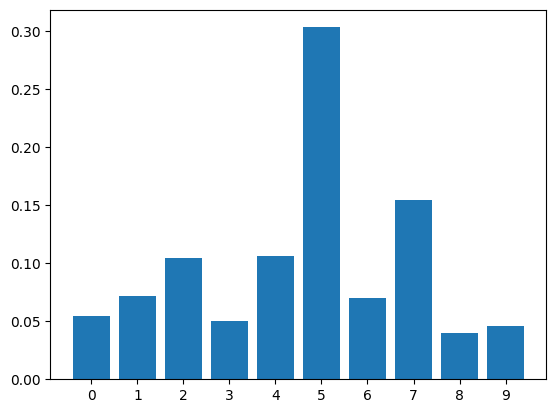

In [ ]:
predict_and_plot(np.expand_dims(shifted_img, 0), model_mnist)

**Q: _Can you comment on the behavior of the model for this specific image? Is it a case of unknown known or unknown unknown? Do you think the image is really OOD, or is the failure of the model here a case of bad model selection/bad inductive biases?_**

Anyway, we can notice that the model is **much less confident** in this case (confidence is around 0.3 for the predicted class 5, while for the random image it was >0.9), so this indicates that there is a sort of "uncertainty" in the prediction.

## Assessing OOD detection capability

Assessing OOD detection capability is a hard task.
Multiple things need to be taken into consideration while deciding the dataset for assessing it:
1. The domain for OOD model is huge, potentially infinite: it's thus impossible to obtain a comprehensive dataset for exhaustively evaluate the potential of the model on OOD detection
2. What is the level of _similarity_ needed between the training dataset and the dataset for assessing OOD detection? In most applications, we might want to get a dataset where the datapoints are _sufficiently similar_ to the data in the trainset, data that the model could encounter while being tested or deployed. For instance, if we train a model to classify paintings, it's probably useless to assess it against images from MNIST or CIFAR10. In other words, the domain of the data should be similar and plausible for the application.

In our case, we will compare our model trained on MNIST against data from Fashion-MNIST. This is a standard OOD test in the literature, especially for toy examples, since (a) both data are natively produced at the same resolution (28x28 pixels) and with similar domain (the images contain grayscale examples of handwritte digits/fashion products and the background is always plain black; in addition, the images contain only the object to be classified, unlike other popular image datasets which contain natural images), and (b) there is no overlap between the classes of MNIST and Fashion MNIST, which makes it the perfect model to evaluate the confidence of the model when being evaluated with unknown unknowns.

![data from Fashion MNIST](https://storage.googleapis.com/kaggle-datasets-images/2243/3791/9384af51de8baa77f6320901f53bd26b/dataset-cover.png)

We first download the Fashion MNIST dataset using keras API:

In [ ]:
_, (x_ood, y_ood) = tf.keras.datasets.fashion_mnist.load_data()
x_ood = preprocess_data(x_ood)

4422102/4422102 [==============================] - 0s 0us/step


**Q: *What does the `_` mean in the expression `_, (x_ood, y_ood) = tf...`? Why is it there?***


We then proceed to evaluate the new data on our keras model, producing the predictions.

In [ ]:
fmnist_predictions = model_mnist.predict(x_ood)

313/313 [==============================] - 1s 2ms/step


We then obtain the confidence value associated to the highest prediction for both MNIST and Fashion MNIST.

The confidence value can be obtained both from the logits (pre-softmax) and from the probability values (post-softmax).
Usually, working with the logits yields better results for OOD detection. **Can we get them directly?**


In [ ]:
pre_softmax_extractor = keras.Model(
    inputs=model_mnist.inputs,
    outputs=model_mnist.layers[-2].output
)

mnist_test_logits = pre_softmax_extractor(x_test)
fmnist_test_logits = pre_softmax_extractor(x_ood)


In [ ]:
mnist_test_logits[:10]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ -5.6996474 ,  -7.923132  ,  -0.25338528,   2.0349963 ,
        -14.204564  ,  -5.713475  , -13.212934  ,   9.0110855 ,
         -2.7225912 ,  -1.7553169 ],
       [ -7.691839  ,   1.0514891 ,  10.993782  ,   0.04135112,
        -22.018658  ,  -8.974573  ,  -7.4417152 , -20.615911  ,
        -11.574631  , -24.597948  ],
       [ -5.838163  ,   4.064906  ,  -2.1353471 ,  -6.0678997 ,
         -4.7933726 ,  -7.3899083 ,  -4.628801  ,  -1.0504667 ,
         -1.0805976 ,  -8.076956  ],
       [ 10.4079    ,  -9.76432   ,  -5.5709047 ,  -8.221415  ,
         -8.369861  ,  -5.22904   ,  -2.0357456 ,  -3.7437184 ,
        -13.474286  ,  -5.9645066 ],
       [  0.23207094, -12.37237   ,  -5.3475633 ,  -6.9197736 ,
          8.501945  ,  -7.15301   ,  -4.46707   ,  -0.24801373,
         -2.327554  ,   1.300501  ],
       [ -7.4397373 ,   5.2786684 ,  -5.560198  ,  -8.274228  ,
         -5.3755713 , -11.557102  ,  -8.765596  ,   0.1361039

**Note: to use logits, just replace `predictions` with `logits`**

In [ ]:
mnist_test_confidence = mnist_test_predictions.max(axis=1)
fmnist_confidence = fmnist_predictions.max(axis=1)

NameError: name 'fmnist_predictions' is not defined

We can immediately compare the two distribution using a visualization method like a boxplot (also density/violin plots are perfectly fine for this task). In the figure below, "1" on the x-axis refers to MNIST, "2" to Fashion MNIST, while the y axis tracks the confidence.

(0.0, 1.0)

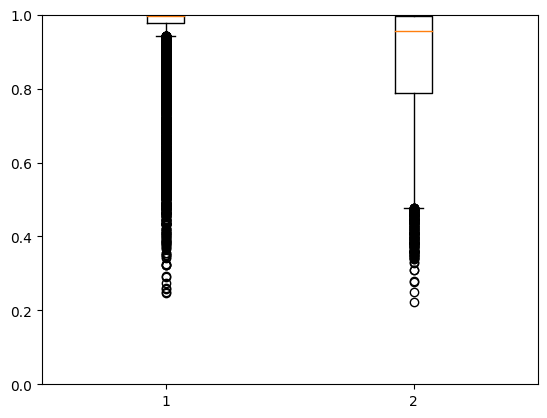

In [ ]:
_ = plt.boxplot([mnist_test_confidence, fmnist_confidence])
plt.ylim((0,1)) # comment if using logits

**Q: _What can you comment on the above chart? What are the main differences between the two distributions?_**



We can quantitatively check the model capability for telling apart ID and OOD data by using the confidence values as _predictors_ for OOD.
We can do so by assigning a synthetic label of 0 for ID data (MNIST) and 1 for OOD data (Fashion MNIST) and see if we can find a confidence threshold which optimally divides the two distributions.
We can measure the performance using one or more metrics for binary classification:
* Accuracy
* FP and/or FN
* F1 score
* ...

**_Other ideas_**?

In [ ]:
def ood_detection_scores(confidence_id, confidence_ood,
                         min_thresh=0.0, max_thresh=1.0, num_steps=101,
                         comparison_fn=np.less):

  ood_label = np.concatenate([
      np.zeros_like(confidence_id),
      np.ones_like(confidence_ood)
  ])

  len_id = len(confidence_id)

  threshold = []
  accuracy = []
  accuracy_id = []
  accuracy_ood = []
  f1_score = []
  # add here other metrics

  for thresh in np.linspace(min_thresh, max_thresh, num_steps):
    detection_scores_id = np.where(comparison_fn(confidence_id, thresh), 1, 0)
    detection_scores_ood = np.where(comparison_fn(confidence_ood, thresh), 1, 0)
    detection_scores = np.concatenate([detection_scores_id, detection_scores_ood])

    acc = M.accuracy_score(ood_label, detection_scores)
    acc_id = M.accuracy_score(ood_label[:len_id], detection_scores_id)
    acc_ood = M.accuracy_score(ood_label[len_id:], detection_scores_ood)
    f1 = M.f1_score(ood_label, detection_scores)
    # add here other metrics

    threshold.append(thresh)
    accuracy.append(acc)
    accuracy_id.append(acc_id)
    accuracy_ood.append(acc_ood)
    f1_score.append(f1)
    # add here other metrics

  ood_detection_scores = pd.DataFrame({
    "threshold": threshold,
    "accuracy": accuracy,
    "accuracy_id": accuracy_id,
    "accuracy_ood": accuracy_ood,
    "f1_score": f1_score,
    # add here other metrics
  })

  return ood_detection_scores

In [ ]:
ood_detection_scores(mnist_test_confidence, fmnist_confidence)

,threshold,accuracy,accuracy_id,accuracy_ood,f1_score
0,0.00,0.50000,1.0000,0.0000,0.000000
1,0.01,0.50000,1.0000,0.0000,0.000000
2,0.02,0.50000,1.0000,0.0000,0.000000
3,0.03,0.50000,1.0000,0.0000,0.000000
4,0.04,0.50000,1.0000,0.0000,0.000000
...,...,...,...,...,...
96,0.96,0.65745,0.8018,0.5131,0.599661
97,0.97,0.65955,0.7749,0.5442,0.615159
98,0.98,0.66055,0.7350,0.5861,0.633245
99,0.99,0.65260,0.6512,0.6540,0.653086


Another common indicator for measuring the _separability_ power of a classifier is the Receiving Operator Curve (ROC) and the corresponding Area Under the Curve (AUC, but often called AUROC or AUC-ROC).
This metric already scans the separability for a multeplicity of thresholds. A perfect separability yields a value of 1.

In [ ]:
def plot_roc(confidence_id, confidence_ood):
  ood_label = np.concatenate([
        np.zeros_like(confidence_id),
        np.ones_like(confidence_ood)
    ])

  true_pos_rate, false_pos_rate, thresh = M.roc_curve(
      ood_label,
      np.concatenate([confidence_id, confidence_ood])
  )
  roc_auc = M.auc(false_pos_rate, true_pos_rate)

  display = M.RocCurveDisplay(fpr=false_pos_rate, tpr=true_pos_rate, roc_auc=roc_auc)
  display.plot()

plot_roc(mnist_test_confidence, fmnist_confidence)

NameError: name 'mnist_test_confidence' is not defined

### Do we get any improvement if we switch to Entropy?

We have made considerations on the confidence in the prediction:

$$
\text{Conf}(\hat{y}) = \max_{c=1,\dots,C} \hat{y}
$$

However, we could also make considerations on the **Entropy** of the prediction

$$
H(\hat{y}) = -\sum_{c=1}^{C} \hat{y}_c \log \hat{y}_c
$$

In [ ]:
def entropy(predictions_array):
  return - (predictions_array * np.log(predictions_array)).sum(axis=1)

In [ ]:
entropy_mnist_test = entropy(mnist_test_predictions)
entropy_fmnist = entropy(fmnist_predictions)

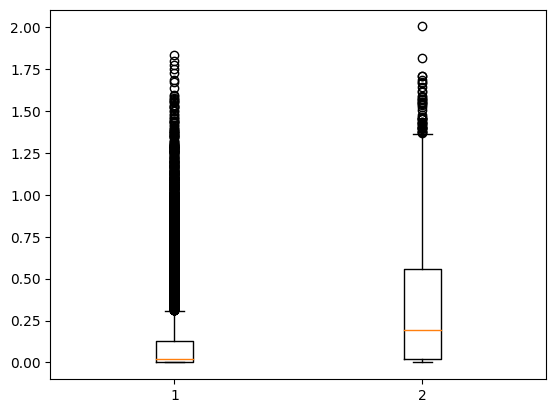

In [ ]:
_ = plt.boxplot((entropy_mnist_test, entropy_fmnist))

In [ ]:
ood_detection_scores(entropy_mnist_test, entropy_fmnist,
                     max_thresh=max(entropy_mnist_test.max(), entropy_fmnist.max()),
                     comparison_fn=np.greater)

,threshold,accuracy,accuracy_id,accuracy_ood,f1_score
0,0.000000,0.50000,0.0000,1.0000,0.666667
1,0.020047,0.61385,0.4777,0.7500,0.660124
2,0.040094,0.63605,0.5844,0.6877,0.653925
3,0.060142,0.64770,0.6445,0.6509,0.648824
4,0.080189,0.65155,0.6866,0.6165,0.638893
...,...,...,...,...,...
96,1.924531,0.50005,1.0000,0.0001,0.000200
97,1.944578,0.50005,1.0000,0.0001,0.000200
98,1.964625,0.50005,1.0000,0.0001,0.000200
99,1.984672,0.50005,1.0000,0.0001,0.000200


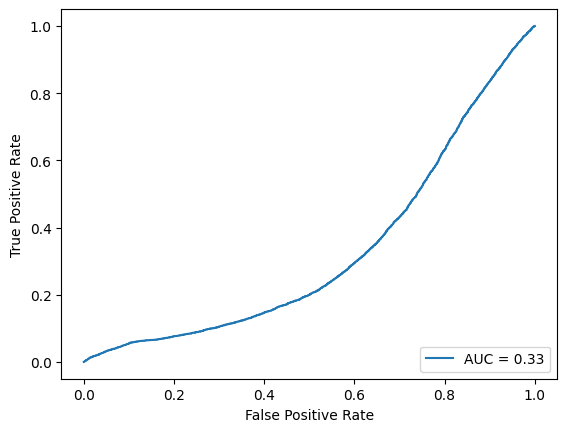

In [ ]:
plot_roc(entropy_mnist_test, entropy_fmnist)

Note: an AUC < 0.5 actually is a good value. Since we have a binary classifier, if it behaves worse than random chance, we can just swap the predictions (i.e., a 0 becomes a 1 and vice versa) to transform it into a "better" predictor. If we do this, the AUC is 1-0.31 which equates to 0.69, the same result we got by using confidence as the probability associated to the highest prediction.

## Switch to a Bayesian model

We have seen that the deterministic NN is unable to effectively tell apart ID and OOD, despite the confidence of the OOD data having a distribution more skewed toward smaller values w.r.t. the ID data.

We can repeat the experiment with a BNN and see if this model is more effective at detecting OOD data.

In [ ]:
def ensemble_component_initializer():
    model = keras.Sequential([
        keras.layers.Input((28, 28, 1)), # data as image: heigth x width x channels. MNIST is grayscale » 1 channel
        keras.layers.Flatten(),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(10),
        keras.layers.Activation("softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

n_components = 5
n_epochs = 15

ensemble = ku.models.DeepEnsembleClassifier(ensemble_component_initializer, num_estimators=n_components)
# Uncomment to train
# ensemble.fit(x, y, epochs=n_epochs)

In [ ]:
# Uncomment to load files
# from google.colab import files

# ensemble.save_weights("mnist_ensemble.keras")
# !zip -r mnist_ensemble.zip mnist_ensemble.keras
# files.download("mnist_ensemble.zip")

Saved estimator weights 0 to mnist_ensemble.keras/ensemble-weights-0.hdf5
Saved estimator weights 1 to mnist_ensemble.keras/ensemble-weights-1.hdf5
Saved estimator weights 2 to mnist_ensemble.keras/ensemble-weights-2.hdf5
Saved estimator weights 3 to mnist_ensemble.keras/ensemble-weights-3.hdf5
Saved estimator weights 4 to mnist_ensemble.keras/ensemble-weights-4.hdf5
  adding: mnist_ensemble.keras/ (stored 0%)
  adding: mnist_ensemble.keras/ensemble-weights-1.hdf5 (deflated 27%)
  adding: mnist_ensemble.keras/ensemble-weights-3.hdf5 (deflated 27%)
  adding: mnist_ensemble.keras/ensemble-weights-2.hdf5 (deflated 27%)
  adding: mnist_ensemble.keras/metadata.yml (deflated 59%)
  adding: mnist_ensemble.keras/ensemble-weights-0.hdf5 (deflated 27%)
  adding: mnist_ensemble.keras/ensemble-weights-4.hdf5 (deflated 27%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
download_weights("https://www.zullich.it/misc/mnist_ensemble.zip", "mnist_ensemble.zip")
!unzip "mnist_ensemble.zip"
ensemble.load_weights("mnist_ensemble.keras")

Archive:  mnist_ensemble.zip
   creating: mnist_ensemble.keras/
  inflating: mnist_ensemble.keras/ensemble-weights-1.hdf5  
  inflating: mnist_ensemble.keras/ensemble-weights-3.hdf5  
  inflating: mnist_ensemble.keras/ensemble-weights-2.hdf5  
  inflating: mnist_ensemble.keras/metadata.yml  
  inflating: mnist_ensemble.keras/ensemble-weights-0.hdf5  
  inflating: mnist_ensemble.keras/ensemble-weights-4.hdf5  


In [ ]:
mnist_test_predictions_bnn = ensemble.predict(x_test)

In [ ]:
fmnist_test_predictions_bnn = ensemble.predict(x_ood)

As we did with the deterministic model, we define the confidence as the maximum value of probability associated with the predicted class.

**Q: _what is the difference in the predictions between the deterministic and the Bayesian model (`mnist_test_predictions` vs `mnist_test_predictions_bnn`)?_**

Answer: the former is just point predictions, the latter is averages from multiple samples.

In [ ]:
mnist_confidence_bnn = mnist_test_predictions_bnn.max(1)
fmnist_confidence_bnn = fmnist_test_predictions_bnn.max(1)

Again, as we did before, we define the `ood_label` to treat as ground truth, create a single vector for the confidence levels, and analyze the accuracy and F1-scores.

In [ ]:
ood_label = np.concatenate([
    np.zeros_like(mnist_confidence_bnn),
    np.ones_like(fmnist_confidence_bnn)
])
confidence_bnn = np.concatenate([
    mnist_confidence_bnn, fmnist_confidence_bnn
])

In [ ]:
ood_detection_scores(mnist_confidence_bnn, fmnist_confidence_bnn)

,threshold,accuracy,accuracy_id,accuracy_ood,f1_score
0,0.00,0.50000,1.0000,0.0000,0.000000
1,0.01,0.50000,1.0000,0.0000,0.000000
2,0.02,0.50000,1.0000,0.0000,0.000000
3,0.03,0.50000,1.0000,0.0000,0.000000
4,0.04,0.50000,1.0000,0.0000,0.000000
...,...,...,...,...,...
96,0.96,0.79850,0.7984,0.7986,0.798520
97,0.97,0.79050,0.7735,0.8075,0.794002
98,0.98,0.77665,0.7329,0.8204,0.786012
99,0.99,0.74995,0.6606,0.8393,0.770459


And we compute the ROC and calculate the AUROC


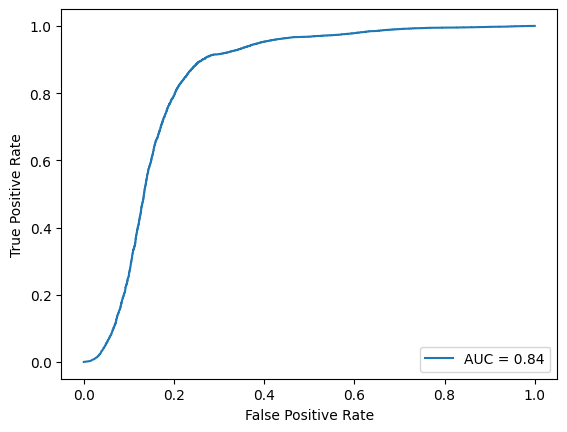

In [ ]:
plot_roc(mnist_confidence_bnn, fmnist_confidence_bnn)

We can also visualize the difference with the boxplots, as we did before

(0.0, 1.0)

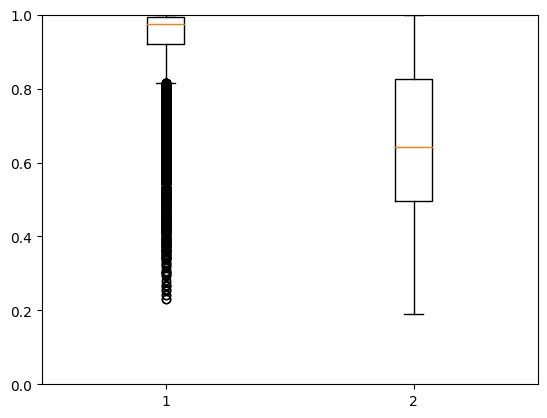

In [ ]:
_ = plt.boxplot([mnist_confidence_bnn, fmnist_confidence_bnn])
plt.ylim((0,1))

**Your task**: repeat this analysis with entropy. Does something change in the metrics for OOD detection?

## Other datasets

We will still look at the OOD capability of our ensemble on two other datasets:

* randomly generated data (we have seen that the frequentist model performed really bad on random data)
* K-MNIST (K-MNIST is a version of MNIST which replaces digits with Japanese Hiragana characters, which are semantically more similar than the clothing items from Fashion-MNIST)

### Random data

We generate the random data by sampling from a *standard* [0,1] uniform distribution, which corresponds to the same domain as MNIST

In [ ]:
random_data = np.random.rand(1000, 28, 28, 1)

random_data_mlp_predictions = model_mnist.predict(random_data)
random_data_ensemble_predictions = ensemble.predict(random_data)

32/32 [==============================] - 0s 3ms/step


In [ ]:
random_data_mlp_confidence = random_data_mlp_predictions.max(1)
random_data_ensemble_confidence = random_data_ensemble_predictions.max(1)

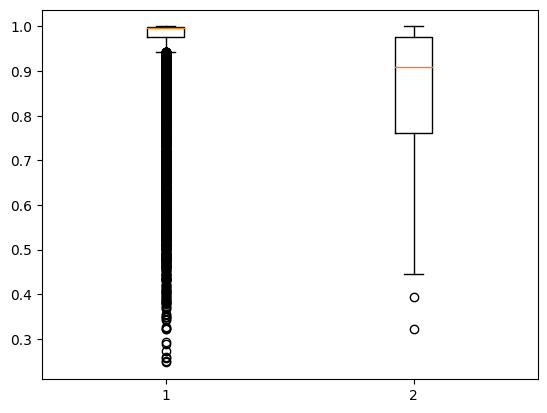

In [ ]:
_ = plt.boxplot([mnist_test_confidence, random_data_mlp_confidence])

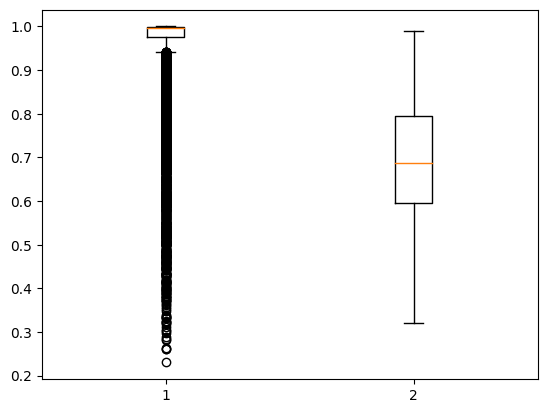

In [ ]:
_ = plt.boxplot([mnist_confidence_bnn, random_data_ensemble_confidence])

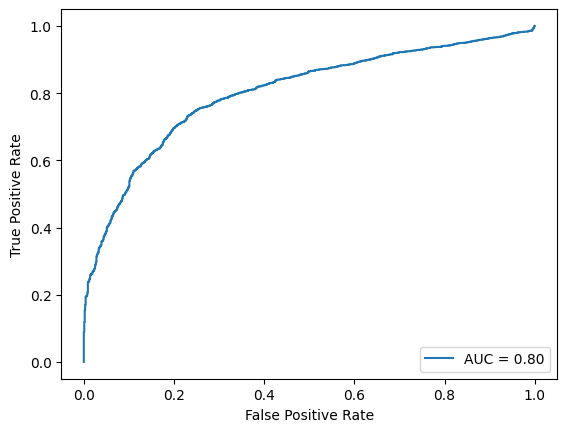

In [ ]:
plot_roc(mnist_test_confidence, random_data_mlp_confidence)

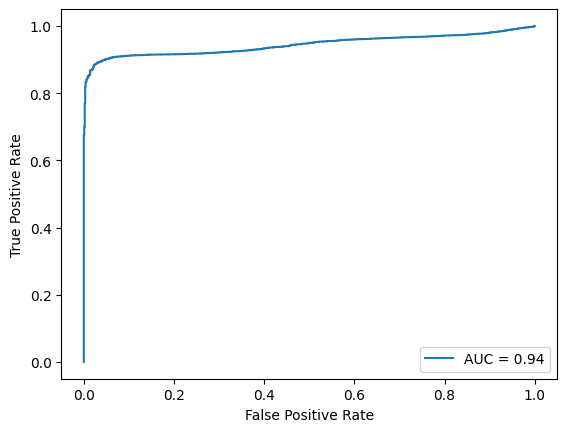

In [ ]:
plot_roc(mnist_confidence_bnn, random_data_ensemble_confidence)

### K-MNIST

In [ ]:
kmnist = tfds.load('kmnist', split='test', shuffle_files=False)
kmnist = np.array([data["image"] for data in list(kmnist)])

kmnist = kmnist.astype(np.float32) / 255

In [ ]:
kmnist_mlp_predictions = model_mnist.predict(kmnist)
kmnist_ensemble_predictions = ensemble.predict(kmnist)

kmnist_mlp_confidence = kmnist_mlp_predictions.max(1)
kmnist_ensemble_confidence = kmnist_ensemble_predictions.max(1)

313/313 [==============================] - 1s 4ms/step


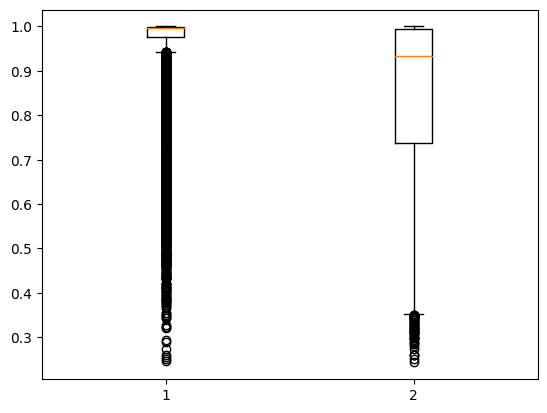

In [ ]:
_ = plt.boxplot([mnist_test_confidence, kmnist_mlp_confidence])

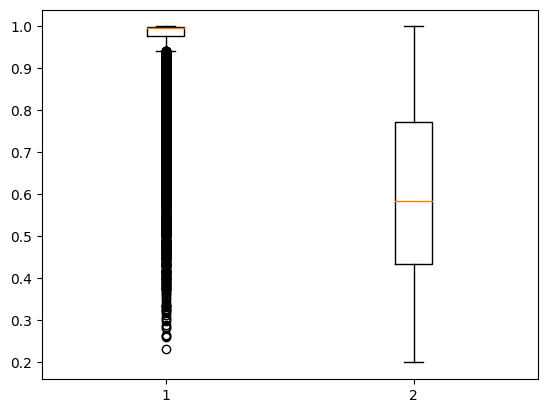

In [ ]:
_ = plt.boxplot([mnist_confidence_bnn, kmnist_ensemble_confidence])

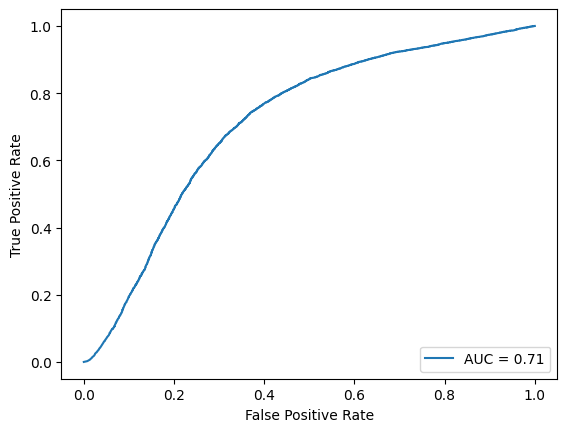

In [ ]:
plot_roc(mnist_test_confidence, kmnist_mlp_confidence)

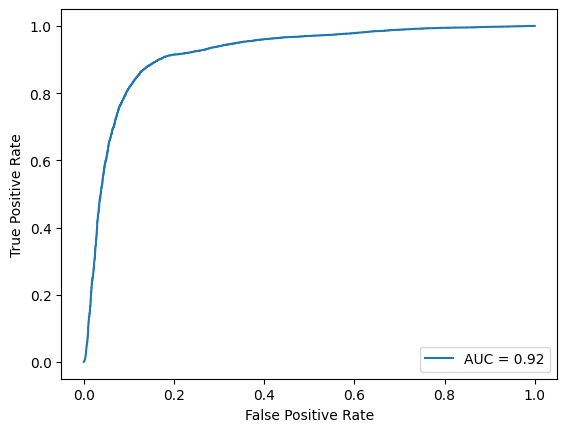

In [ ]:
plot_roc(mnist_confidence_bnn, kmnist_ensemble_confidence)